In [26]:
import ee
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.model_selection import GroupKFold
import joblib

pd.set_option('display.max_rows', None)

# Authenticate Earth Engine only once; then run ee.Initialize()
ee.Initialize(project='awesome-carver-365303')

In [2]:
df = pd.read_csv('/Users/silviaaaaaa/Library/CloudStorage/GoogleDrive-shiyu.ding66@gmail.com/My Drive/Learning/Ornithology/Common Nighthawk Study/Data/gravel_training_samples_8-5.csv')

In [25]:
df.head()

,system:index,B,G,N,NDVI,NDVI_contrast,R,class,poly_id,.geo,fold,y_pred,y_prob
0,1_000400000000000204fb_0,72,66,34,-0.235955,90.346230,55,1,0.0,"{""geodesic"":false,""type"":""Point"",""coordinates""...",1,0,0.000
1,1_000400000000000204fb_1,154,163,157,-0.024845,79.972222,165,1,0.0,"{""geodesic"":false,""type"":""Point"",""coordinates""...",1,0,0.090
2,1_000400000000000204fb_2,139,151,143,-0.033784,75.208333,153,1,0.0,"{""geodesic"":false,""type"":""Point"",""coordinates""...",1,0,0.325
3,1_000400000000000204fb_3,143,154,150,-0.019608,68.703373,156,1,0.0,"{""geodesic"":false,""type"":""Point"",""coordinates""...",1,0,0.060
4,1_000400000000000204fb_4,149,160,158,-0.009404,4.363095,161,1,0.0,"{""geodesic"":false,""type"":""Point"",""coordinates""...",1,0,0.290


In [ ]:
df.poly_id.value_counts()

poly_id
1.0      13596
154.0     7179
108.0     6964
39.0      6649
5.0       4922
         ...  
10.0        81
44.0        77
12.0        72
46.0        68
47.0        55
Name: count, Length: 158, dtype: int64

In [4]:
feature_cols = ['R','G','B','N','NDVI','NDVI_contrast']  # CHANGE to match your CSV
X = df[feature_cols].values
y = df['class'].values
groups = df['poly_id']

In [ ]:
# 4) grouped cross-validation (hold out polygon groups)
# create a GroupKFold object with 5 splits
gkf = GroupKFold(n_splits=5)
# instantiate a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=42)
# Store predictions for analysis
df['fold'] = -1
df['y_pred'] = -1
df['y_prob'] = np.nan
scores = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
    rf.fit(X[train_idx], y[train_idx])

    # probability for class=1 (gravel) on the test fold
    probas = rf.predict_proba(X[test_idx])[:, 1]

    preds = rf.predict(X[test_idx])  # default threshold for classification is 0.5 here
    df.loc[test_idx, 'fold'] = fold
    df.loc[test_idx, 'y_pred'] = preds
    df.loc[test_idx, 'y_prob'] = probas
    scores.append(classification_report(y[test_idx], preds, output_dict=True)['1'])
    print(f"Fold {fold} report:\n", classification_report(y[test_idx], preds))
print('per-fold results (gravel class):', scores)

Fold 0 report:
               precision    recall  f1-score   support

           0       0.74      0.98      0.85     16754
           1       0.96      0.58      0.73     13596

    accuracy                           0.80     30350
   macro avg       0.85      0.78      0.79     30350
weighted avg       0.84      0.80      0.79     30350

Fold 1 report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     26751
           1       0.78      0.33      0.46      3603

    accuracy                           0.91     30354
   macro avg       0.85      0.66      0.70     30354
weighted avg       0.90      0.91      0.89     30354

Fold 2 report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     27204
           1       0.70      0.56      0.62      3149

    accuracy                           0.93     30353
   macro avg       0.82      0.77      0.79     30353
weighted avg       0.92   

In [27]:
# threshold analysis

fpr, tpr, roc_thresh = roc_curve(y, df['y_prob'])
J = tpr - fpr
best_thresh = roc_thresh[J.argmax()]
print(f"Best threshold (Youden's J): {best_thresh:.3f}")

prec, rec, pr_thresh = precision_recall_curve(y, df['y_prob'])
f1_scores = [f1_score(y, df['y_prob'] >= t) for t in pr_thresh]
best_thresh_f1 = pr_thresh[np.argmax(f1_scores)]
print(f"Best threshold (F1): {best_thresh_f1:.3f}")


Best threshold (Youden's J): 0.220
Best threshold (F1): 0.375


In [6]:
# Summarize the scores over folds
precision_scores = [fold['precision'] for fold in scores]
recall_scores = [fold['recall'] for fold in scores]
f1_scores = [fold['f1-score'] for fold in scores]

print(f"Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}")
print(f"Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}")
print(f"F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")

Precision: 0.690 ± 0.234
Recall: 0.565 ± 0.178
F1-score: 0.559 ± 0.118


* Precision: Of all pixels predicted as gravel, how many were actually gravel? (Higher means fewer false positives.)

* Recall: Of all actual gravel pixels, how many did your model correctly find? (Higher means fewer false negatives.)

* F1-score: The harmonic mean of precision and recall, balances the two.

* Support: How many actual gravel pixels were in this test fold.

We can tell from above the 5 fold performance variance is high, which means model is not generalized enough.

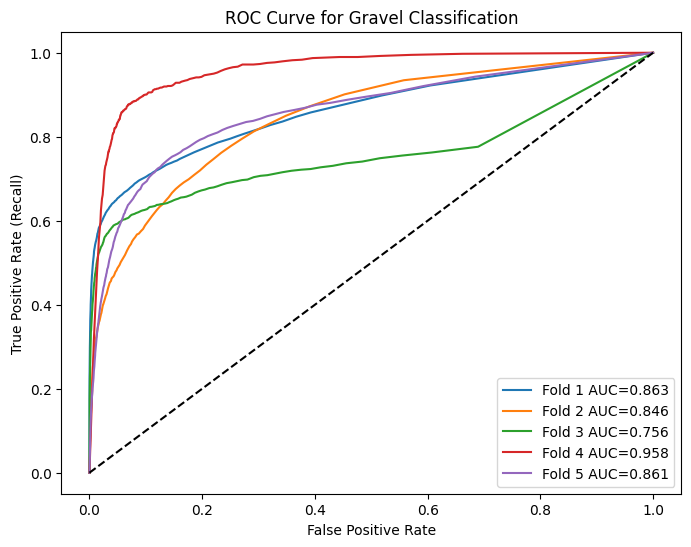

In [7]:
#Plot ROC curve & calculate AUC (per fold)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
    rf.fit(X[train_idx], y[train_idx])
    probs = rf.predict_proba(X[test_idx])[:, 1]  # probability of class 1
    fpr, tpr, _ = roc_curve(y[test_idx], probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Fold {i+1} AUC={roc_auc:.3f}')

plt.plot([0,1], [0,1], 'k--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Gravel Classification')
plt.legend()
plt.show()


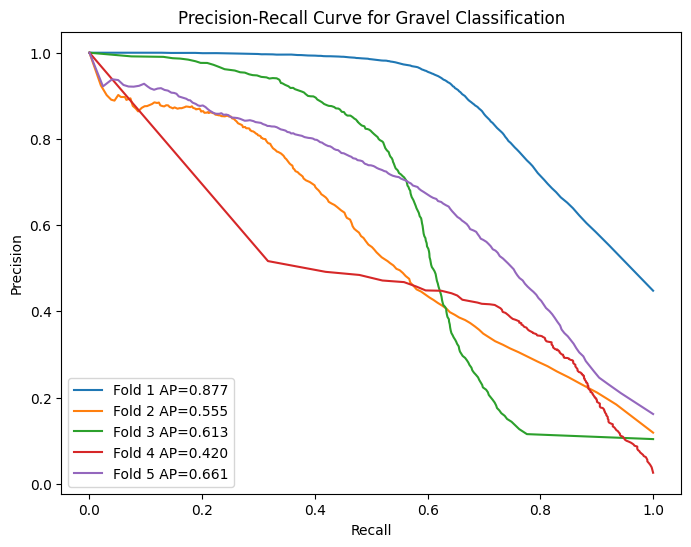

In [8]:
# Use Precision-Recall curve for imbalanced data - when true negative (non-gravel) is very large
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
    rf.fit(X[train_idx], y[train_idx])
    probs = rf.predict_proba(X[test_idx])[:, 1]
    precision, recall, _ = precision_recall_curve(y[test_idx], probs)
    ap = average_precision_score(y[test_idx], probs)
    plt.plot(recall, precision, label=f'Fold {i+1} AP={ap:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Gravel Classification')
plt.legend()
plt.show()


In [18]:
# Per polygon accuracy
poly_stats = (
    df.groupby(['poly_id'])
      .apply(lambda g: (g['y_pred'] == g['class']).mean())
      .reset_index(name='poly_accuracy')
)

# Merge with class label (gravel or not)
poly_stats = poly_stats.merge(df[['poly_id','class']].drop_duplicates(), on='poly_id')

# Sort by accuracy
poly_stats = poly_stats.sort_values('poly_accuracy')
print(poly_stats)


     poly_id  poly_accuracy  class
7        7.0       0.290214      1
4        4.0       0.301932      1
0        0.0       0.392250      1
155    155.0       0.422577      0
2        2.0       0.460808      1
5        5.0       0.480496      1
3        3.0       0.578812      1
1        1.0       0.584731      1
30      30.0       0.660494      0
132    132.0       0.754667      0
55      55.0       0.771104      0
135    135.0       0.818713      0
10      10.0       0.864198      0
6        6.0       0.872286      1
48      48.0       0.881002      0
125    125.0       0.888889      0
46      46.0       0.897059      0
118    118.0       0.904694      0
94      94.0       0.906810      0
116    116.0       0.907441      0
86      86.0       0.909639      0
19      19.0       0.921090      0
49      49.0       0.923651      0
17      17.0       0.924569      0
100    100.0       0.927984      0
18      18.0       0.928931      0
14      14.0       0.930556      0
53      53.0       0

/var/folders/3w/875q3kbn2blb9zwp1zjfrhfc0000gn/T/ipykernel_67852/1729179490.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g['y_pred'] == g['class']).mean())


In [10]:
# 5) final fit on full training set & save model
rf.fit(X, y)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
# 6) feature importance
importances = rf.feature_importances_
for f, imp in zip(feature_cols, importances):
    print(f, imp)

R 0.16613745696214152
G 0.16222122956246288
B 0.2172284308636702
N 0.11683917079716659
NDVI 0.20421839676650633
NDVI_contrast 0.13335531504805243
